In [2]:
pip install pymoo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 5.2 MB/s 
     |████████████████████████████████| 249 kB 53.6 MB/s 
     |████████████████████████████████| 80 kB 9.1 MB/s 
     |████████████████████████████████| 207 kB 43.9 MB/s 
  Created wheel for grapheme: filename=grapheme-0.6.0-py3-none-any.whl size=210096 sha256=ab43e40c668d144e4f7ce0fd81e376f4280f81d0dbe8dd47dc34e164e8f3215b
  Stored in directory: /root/.cache/pip/wheels/71/fc/c8/142ef03b79c02b618fe80b9f2d01c25bd55f60b0c58eab3f0e
Successfully built grapheme


#Implement the Problem
The function being responsible for the evaluation is _evaluate which shall be implemented next. The function’s interface is the parameters x and out. For this element-wise implementation x is a one-dimensional NumPy array of length n_var which represents a single solution to be evaluated. The output is supposed to be written to the dictionary out. The objective values should be written to out["F"] as a list of NumPy array with length of n_obj and the constraints to out["G"] with length of n_constr (if the problem has constraints to be satisfied at all).

In [5]:
import numpy as np
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var=2,
                         n_obj=2,
                         n_ieq_constr=2,
                         xl=np.array([-2,-2]),
                         xu=np.array([2,2]))

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = 100 * (x[0]**2 + x[1]**2)
        f2 = (x[0]-1)**2 + x[1]**2

        g1 = 2*(x[0]-0.1) * (x[0]-0.9) / 0.18
        g2 = - 20*(x[0]-0.4) * (x[0]-0.6) / 4.8

        out["F"] = [f1, f2]
        out["G"] = [g1, g2]


problem = MyProblem()

#Initialize an Algorithm
n our case, the optimization problem is rather simple, but the aspect of having two objectives and two constraints should be considered. Thus, let us select the well-known multi-objective algorithm NSGA-II. For the majority of algorithms you could either choose the default hyper-parameters or create your own version of the algorithm by modifying them. For instance, for this relatively simple problem we choose a population size of 40 (`pop_size=40`) and with only 10 (`n_offsprings=10`) in each generation. Such an implementation is a greedier variant and improves the convergence of simpler optimization problems without major difficulties regarding optimization, such as the existence of local Pareto-fronts. Moreover, we enable a duplicate check (`eliminate_duplicates=True`), making sure that the mating produces offsprings that are different from themselves and the existing population regarding their design space values.

In [6]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling

algorithm = NSGA2(
    pop_size=40,
    n_offsprings=10,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

#Define a Termination Criterion 
Furthermore, a termination criterion needs to be defined to start the optimization procedure. Most common ways of defining the termination is by limiting the overall number of function evaluations or simply the number of iterations of the algorithm.

In [7]:
from pymoo.termination import get_termination

termination = get_termination("n_gen", 40)

#Optimize
Finally, we are solving the problem with the algorithm and termination we have defined. The functional interface uses the minimize method. By default, the minimize performs deep-copies of the algorithm and the termination object which guarantees they are not modified during the function call. This is important to ensure that repetitive function calls with the same random seed end up with the same results. When the algorithm has been terminated, the minimize function returns a Result object.

In [8]:
from pymoo.optimize import minimize

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

X = res.X
F = res.F

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       40 |      1 |  0.000000E+00 |  2.363992E+01 |             - |             -
     2 |       50 |      1 |  0.000000E+00 |  1.262978E+01 |  0.000000E+00 |             f
     3 |       60 |      2 |  0.000000E+00 |  5.3749132447 |  1.0000000000 |         ideal
     4 |       70 |      2 |  0.000000E+00 |  2.4309071542 |  0.000000E+00 |             f
     5 |       80 |      3 |  0.000000E+00 |  0.9326371456 |  0.0096178563 |         ideal
     6 |       90 |      3 |  0.000000E+00 |  0.1066499133 |  0.0601661450 |         ideal
     7 |      100 |      3 |  0.000000E+00 |  0.0092174421 |  0.000000E+00 |             f
     8 |      110 |      5 |  0.000000E+00 |  0.0010944863 |  0.2816759453 |         ideal
     9 |      120 |      6 |  0.000000E+00 |  0.000000E+00 |  0.0124399889 |             f
    10 |      130 |      9 |  0.000000E+00 |  0.000000E+00 |  0.0041045275 |         ideal

#Visualize
Analyzing the solutions being found by the algorithm is vital. Always a good start is visualizing the solutions to get a grasp of commonalities or if the Pareto-front is known to even check the convergence.

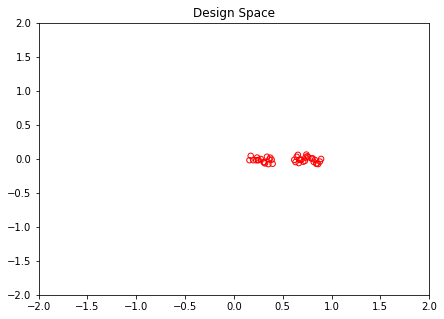

In [9]:
import matplotlib.pyplot as plt
xl, xu = problem.bounds()
plt.figure(figsize=(7, 5))
plt.scatter(X[:, 0], X[:, 1], s=30, facecolors='none', edgecolors='r')
plt.xlim(xl[0], xu[0])
plt.ylim(xl[1], xu[1])
plt.title("Design Space")
plt.show()

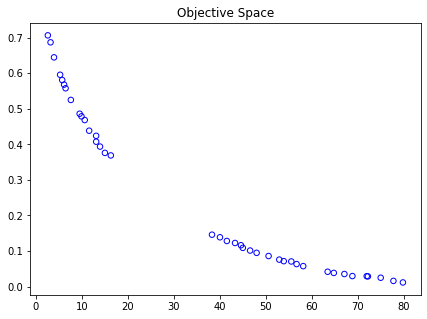

In [10]:
plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.title("Objective Space")
plt.show()